# PSD raw trace

author: laquitainesteeve@gmail.com


**Method**: 

* Welch method with 1Hz resolution, Hann window.

## Setup

1. Compute power spectral data with src.pipes.validation.psd.multiprocess (~3 min)
2. Activate `spikebias` venv

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import spikeinterface as si
import copy
import multiprocessing
import torch
import seaborn as sns
import pandas as pd
from scipy.stats import kruskal # stats
import scikit_posthocs as sp

# move to PROJECT PATH
PROJ_PATH = "/home/steeve/steeve/epfl/code/spikebias"
os.chdir(PROJ_PATH)

from src.nodes import utils
from src.nodes.utils import get_config, get_stats_config
from src.nodes.validation import power

matplotlib.rcParams['agg.path.chunksize'] = 10000

# SETUP PARAMETERS
prm = dict()
prm["SFREQ_HV"] = 20000        # sampling frequency
prm["SFREQ_HS"] = 20000        # sampling frequency
prm["SFREQ_NV"] = 30000        # sampling frequency
prm["SFREQ_NS"] = 40000        # sampling frequency
prm["SFREQ_NB"] = 32000
prm["SFREQ_NE"] = 20000

# setup paths

# neuropixels recordings
RAW_PATH_ns = "dataset/00_raw/recording_npx_spont"  # full
RAW_PSD_PATH_NS = "dataset/01_intermediate/psds/psd_raw_npx_spont.npy"
RAW_PATH_ne = "dataset/00_raw/recording_npx_evoked" # full
RAW_PSD_PATH_NE = "dataset/01_intermediate/psds/psd_raw_npx_evoked.npy"
RAW_PATH_nb = "dataset/00_raw/recording_buccino_rep" # full
RAW_PSD_PATH_NB = "dataset/01_intermediate/psds/psd_raw_buccino.npy"
RAW_PATH_ms = "dataset/00_raw/recording_marques_smith" # full
RAW_PSD_PATH_MS = "dataset/01_intermediate/psds/psd_raw_marques_smith.npy"

# dense recordings
RAW_PATH_hv1 =  "dataset/00_raw/recording_horvath_probe1"
RAW_PSD_PATH_HV1 = "dataset/01_intermediate/psds/psd_raw_horvath_probe1.npy"
RAW_PATH_hv2 =  "dataset/00_raw/recording_horvath_probe2"
RAW_PSD_PATH_HV2 = "dataset/01_intermediate/psds/psd_raw_horvath_probe2.npy"
RAW_PATH_hv3 =  "dataset/00_raw/recording_horvath_probe3"
RAW_PSD_PATH_HV3 = "dataset/01_intermediate/psds/psd_raw_horvath_probe3.npy"
RAW_PATH_hs1 = "dataset/00_raw/recording_dense_probe1"
RAW_PSD_PATH_HS1 = "dataset/01_intermediate/psds/psd_raw_dense_probe1.npy"
RAW_PATH_hs2 = "dataset/00_raw/recording_dense_probe2"
RAW_PSD_PATH_HS2 ="dataset/01_intermediate/psds/psd_raw_dense_probe2.npy"
RAW_PATH_hs3 = "dataset/00_raw/recording_dense_probe3"
RAW_PSD_PATH_HS3 = "dataset/01_intermediate/psds/psd_raw_dense_probe3.npy"

# pipeline parameters
SAVE_FIG = True
SAVE_TEMP_DATA = True
LOAD_TEMP_DATA = False

PLOT_DATA_PATH_NPX = "dataset/02_figure_dataset/fig2u_data_fscaling_npx.parquet"
PLOT_DATA_PATH_DENSE = "dataset/02_figure_dataset/fig2u_data_fscaling_dense.parquet"

# FIGURE SETTINGS
FIG_SIZE = (1.5, 1.5)
# experiment colors
cl = dict()
cl["COLOR_NV"] = [0.6, 0.6, 0.6]
cl["COLOR_NS"] = [0.9, 0.14, 0.15]
cl["COLOR_NB"] = [0.22, 0.5, 0.72] # blue
cl["COLOR_NE"] = [1, 0.49, 0] # orange
cl["COLOR_MEDIAN"] = (1, 0.76, 0)
cl["COLOR_HV"] = "k" # black
cl["COLOR_HS"] = np.array([26, 152, 80]) / 255 # green

# axes aesthetics
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
N_MAJOR_TICKS = 4
N_MINOR_TICKS = 12
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame


# parameterize
FIG_SIZE = (1, 1)
pm = {
    "linestyle": "None",
    "marker": "o",
    "markersize": 1.5,
    "rasterized": True,
    "markeredgecolor": "w",
    "markeredgewidth": 0.06,
}
pm_fit1 = {
    "linestyle": "-",
    "linewidth": 0.5,
    "color": "k",
}
pm_fit2 = {
    "linestyle": "-",
    "linewidth": 0.5,
    "color": "k",
}

### Specs

In [2]:
# cpus, gpu and current memory usage
print("available cpus:", multiprocessing.cpu_count())
print("available gpus:", torch.cuda.is_available())
%system free -m

available cpus: 32
available gpus: True


['               total        used        free      shared  buff/cache   available',
 'Mem:          192987       24259      119362         309       51341      168728',
 'Swap:           8191        4335        3856']

### Custom functions

In [3]:
def print_slope(alpha):
    print(f"\u03B1={np.round(np.mean(alpha),1)}\u00B1{np.round(np.std(alpha),1)}")


def get_slope_df(data: list, exp, layer):
    df = pd.DataFrame()
    df["Alpha"] = np.negative(data)
    df["Experiment"] = exp
    df["Layer"] = layer
    return df

### (1s)Load dataset

* select first 10 min for speed

In [4]:
# Load traces
# neuropixels
# raw
RawMS = si.load_extractor(RAW_PATH_ms)
RawNS = si.load_extractor(RAW_PATH_ns)
RawNE = si.load_extractor(RAW_PATH_ne)
RawNB = si.load_extractor(RAW_PATH_nb)

# horvath
# raw (probe 1)
RawHV1 = si.load_extractor(RAW_PATH_hv1)
RawHS1 = si.load_extractor(RAW_PATH_hs1)
RawHV2 = si.load_extractor(RAW_PATH_hv2)
RawHS2 = si.load_extractor(RAW_PATH_hs2)
RawHV3 = si.load_extractor(RAW_PATH_hv3)
RawHS3 = si.load_extractor(RAW_PATH_hs3)

# 4 - get good sites (in cortex) **********************
# neuropixels
lyrs = ["L1", "L2_3", "L4", "L5", "L6"]
# spontaneous
site_ly_ns = RawNS.get_property("layers")
site_ly_ns[site_ly_ns == "L2"] = "L2_3"
site_ly_ns[site_ly_ns == "L3"] = "L2_3"
sites_ns = np.where(np.isin(site_ly_ns, lyrs))[0]
# evoked
site_ly_ne = RawNE.get_property("layers")
site_ly_ne[site_ly_ne == "L2"] = "L2_3"
site_ly_ne[site_ly_ne == "L3"] = "L2_3"
sites_ne = np.where(np.isin(site_ly_ne, lyrs))[0]
# marques-smith
site_ly_nv = RawMS.get_property("layers")
sites_nv = np.where(np.isin(site_ly_nv, lyrs))[0]

# simulated dense recording
site_ly_hs1 = RawHS1.get_property("layers")
site_ly_hs1 = np.array(["L2_3" if x == "L2" or x == "L3" else x for x in site_ly_hs1])
sites_hs1 = np.where(np.isin(site_ly_hs1, ["L1", "L2_3"]))[0]
site_ly_hs2 = RawHS2.get_property("layers")
sites_hs2 = np.where(np.isin(site_ly_hs2, ["L4", "L5"]))[0]
site_ly_hs3 = RawHS3.get_property("layers")
site_ly_hs3 = np.array(["L2_3" if x == "L2" or x == "L3" else x for x in site_ly_hs3])
sites_hs3 = np.where(np.isin(site_ly_hs3, ["L6"]))[0]

# horvath recording
site_ly_hv1 = RawHV1.get_property("layers")
sites_hv1 = np.where(np.isin(site_ly_hv1, ["L1", "L2_3"]))[0]
site_ly_hv2 = RawHV2.get_property("layers")
sites_hv2 = np.where(np.isin(site_ly_hv2, ["L4", "L5"]))[0]
site_ly_hv3 = RawHV3.get_property("layers")
sites_hv3 = np.where(np.isin(site_ly_hv3, ["L6"]))[0]

# Load pre-computed PSDs
psd_raw_ms = np.load(RAW_PSD_PATH_MS, allow_pickle=True).item()
psd_raw_ns = np.load(RAW_PSD_PATH_NS, allow_pickle=True).item()
psd_raw_ne = np.load(RAW_PSD_PATH_NE, allow_pickle=True).item()
psd_raw_nb = np.load(RAW_PSD_PATH_NB, allow_pickle=True).item()
psd_raw_hv1 = np.load(RAW_PSD_PATH_HV1, allow_pickle=True).item()
psd_raw_hv2 = np.load(RAW_PSD_PATH_HV2, allow_pickle=True).item()
psd_raw_hv3 = np.load(RAW_PSD_PATH_HV3, allow_pickle=True).item()
psd_raw_hs1 = np.load(RAW_PSD_PATH_HS1, allow_pickle=True).item()
psd_raw_hs2 = np.load(RAW_PSD_PATH_HS2, allow_pickle=True).item()
psd_raw_hs3 = np.load(RAW_PSD_PATH_HS3, allow_pickle=True).item()

# neuropixels
# horvath vivo (all layers)
# L1 (probe 1)
psd_raw_hv1_L1 = copy.copy(psd_raw_hv1)
psd_raw_hv1_L1["power"] = psd_raw_hv1["power"][site_ly_hv1[sites_hv1] == "L1", :]
# L23 (probe 1)
psd_raw_hv1_L23 = copy.copy(psd_raw_hv1)
psd_raw_hv1_L23["power"] = psd_raw_hv1["power"][site_ly_hv1[sites_hv1] == "L2_3", :]
# L4 (probe 2)
psd_raw_hv2_L4 = copy.copy(psd_raw_hv2)
psd_raw_hv2_L4["power"] = psd_raw_hv2["power"][site_ly_hv2[sites_hv2] == "L4", :]
# L5 (probe 2)
psd_raw_hv2_L5 = copy.copy(psd_raw_hv2)
psd_raw_hv2_L5["power"] = psd_raw_hv2["power"][site_ly_hv2[sites_hv2] == "L5", :]
# L6 (probe 3)
psd_raw_hv3_L6 = copy.copy(psd_raw_hv3)
psd_raw_hv3_L6["power"] = psd_raw_hv3["power"][site_ly_hv3[sites_hv3] == "L6", :]

# sites in target layers in each probe
psd_all_hv = dict()
psd_all_hv["power"] = np.vstack(
    [
        psd_raw_hv1_L1["power"],
        psd_raw_hv1_L23["power"],
        psd_raw_hv2_L4["power"],
        psd_raw_hv2_L5["power"],
        psd_raw_hv3_L6["power"],
    ]
)
psd_all_hv["freq"] = psd_raw_hv1["freq"]

# horvath biophy. spont. (all layers) **************************

# L1 (probe 1)
psd_raw_hs1_L1 = copy.copy(psd_raw_hs1)
psd_raw_hs1_L1["power"] = psd_raw_hs1["power"][site_ly_hs1[sites_hs1] == "L1", :]
# L23 (probe 1)
psd_raw_hs1_L23 = copy.copy(psd_raw_hs1)
psd_raw_hs1_L23["power"] = psd_raw_hs1["power"][site_ly_hs1[sites_hs1] == "L2_3", :]
# L4 (probe 2)
psd_raw_hs2_L4 = copy.copy(psd_raw_hs2)
psd_raw_hs2_L4["power"] = psd_raw_hs2["power"][site_ly_hs2[sites_hs2] == "L4", :]
# L5 (probe 2)
psd_raw_hs2_L5 = copy.copy(psd_raw_hs2)
psd_raw_hs2_L5["power"] = psd_raw_hs2["power"][site_ly_hs2[sites_hs2] == "L5", :]
# L6 (probe 3)
psd_raw_hs3_L6 = copy.copy(psd_raw_hs3)
psd_raw_hs3_L6["power"] = psd_raw_hs3["power"][site_ly_hs3[sites_hs3] == "L6", :]

# sites in target layers in each probe
psd_all_hs = dict()
psd_all_hs["power"] = np.vstack(
    [
        psd_raw_hs1_L1["power"],
        psd_raw_hs1_L23["power"],
        psd_raw_hs2_L4["power"],
        psd_raw_hs2_L5["power"],
        psd_raw_hs3_L6["power"],
    ]
)
psd_all_hs["freq"] = psd_raw_hs1["freq"]


# unit-test power spectral density resolutions
assert psd_raw_hv1["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_hv2["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_hv3["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_hs1["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_hs2["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_hs3["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_ms["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_ns["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_ne["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_nb["freq"][1] == 1.0, "psd resolution should be 1Hz"

# Plot

across layers


LFP band

Horvath:
α=-2.3±0.2

Marques-smith:
α=-0.6±0.1

npx spont model:
α=-0.3±0.0

npx evoked model:
α=-0.5±0.2

dense model:
α=-0.3±0.0


n=272 sites
n=226 sites
n=202 sites
n=202 sites
n=297 sites


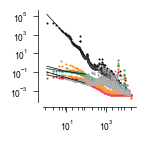

In [25]:
FIG_SIZE = (1.2,1.2)

# we rasterize, else dots increase file size by
# 6MB per plot
# takes 2 mins
YLIM_AX1 = [0, 0.02]
YLIM_AX2 = [0, 0.08]
N_MAJOR_TICKS = 4
ALPHA = 0.7

fig, ax1 = plt.subplots(1, 1, figsize=FIG_SIZE)

# Fit panel ************************************************************

ax1, alphas_lfp_hv, alphas_spiking_hv = power.plot_fits_all(
    ax1, psd_all_hv, prm["SFREQ_HV"], cl["COLOR_HV"], pm, pm_fit1, pm_fit2, plot_spiking_slope=False
)
ax1, alphas_lfp_ns, alphas_spiking_ns = power.plot_fits_all(
    ax1, psd_raw_ns, prm["SFREQ_NS"], cl["COLOR_NS"], pm, pm_fit1, pm_fit2, plot_spiking_slope=False
)
ax1, alphas_lfp_ne, alphas_spiking_ne = power.plot_fits_all(
    ax1, psd_raw_ne, prm["SFREQ_NE"], cl["COLOR_NE"], pm, pm_fit1, pm_fit2, plot_spiking_slope=False
)
ax1, alphas_lfp_hs, alphas_spiking_hs = power.plot_fits_all(
    ax1, psd_all_hs, prm["SFREQ_HS"], cl["COLOR_HS"], pm, pm_fit1, pm_fit2, plot_spiking_slope=False
)
ax1, alphas_lfp_ms, alphas_spiking_ms = power.plot_fits_all(
    ax1, psd_raw_ms, prm["SFREQ_NV"], cl["COLOR_NV"], pm, pm_fit1, pm_fit2, plot_spiking_slope=False
)

# axes legend
# esthetics
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.spines[["top", "right"]].set_visible(False)
# minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.2, 0.4, 0.6, 0.8),
    numticks=N_MINOR_TICKS,
)
ax1.tick_params(which="both")
ax1.xaxis.set_major_locator(locmaj)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# disconnect axes (R style)
ax1.spines["bottom"].set_position(("axes", -0.05))
ax1.yaxis.set_ticks_position("left")
ax1.spines["left"].set_position(("axes", -0.05))

# report slopes
# lfp band
print("\nLFP band")
print('\nHorvath:'); print_slope(alphas_lfp_hv)
print('\nMarques-smith:'); print_slope(alphas_lfp_ms)
print('\nnpx spont model:'); print_slope(alphas_lfp_ns)
print('\nnpx evoked model:'); print_slope(alphas_lfp_ne)
print('\ndense model:'); print_slope(alphas_lfp_hs)

# print sites
print("\n")
print(f"""n={psd_all_hv["power"].shape[0]} sites""")
print(f"""n={psd_raw_ms["power"].shape[0]} sites""")
print(f"""n={psd_raw_ns["power"].shape[0]} sites""")
print(f"""n={psd_raw_ne["power"].shape[0]} sites""")
print(f"""n={psd_all_hs["power"].shape[0]} sites""")

# save
plt.savefig("figures/6_supp/fig2/fig2_raw_power_fit_full_circuit.svg", **savefig_cfg)

In [24]:
print("scale of change:", np.mean(alphas_lfp_hv) / np.mean(alphas_lfp_ms))

print(np.hstack([alphas_lfp_ns, alphas_lfp_ne, alphas_lfp_hs]).mean())
print(np.hstack([alphas_lfp_ns, alphas_lfp_ne, alphas_lfp_hs]).std())

scale of change: 3.7469041295253733
-0.37539253483913904
0.1601683198705626


# References

see plot of known frequency scaling properties of LFP (http://www.scholarpedia.org/article/File:Diffusion-LFP.jpg)
